In [1]:
source("/frazer01/projects/CEGS/analysis/hla_type_1kgp/script/functions_hla_type.R")


# Get subject IDs

In [86]:
id2cv = fread("pipeline/beagle/1kgp_validation/id2cv.txt", sep = "\t", header = TRUE, data.table = FALSE)
ids   = id2cv$id
bins  = sort(unique(id2cv$bin))

# Read real HLA types

In [43]:
command = paste("bcftools", "query",
                "-s", paste(ids, collapse = ","),
                "-f", "'%ID\\t%AF[\\t%GN]\\n'",
                vcf_hla_types
               )

hla_real           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
colnames(hla_real) = c("hla_type", "af", ids)
rownames(hla_real) = hla_real$hla_type

# Read imputed HLA types

In [45]:
read_imputed_hla = function(bin, id2cv)
{
    ids             = id2cv[ id2cv$bin == bin, "id"]
    vcf_imputed_hla = paste(getwd(), "pipeline/beagle/1kgp_validation/processing", paste0("bin", bin), "imputed_hla.vcf.gz", sep = "/")
    command = paste("bcftools", "query",
                    "-s", paste(ids, collapse = ","),
                    "-f", "'%ID\\t%AF[\\t%DS]\\n'",
                    vcf_imputed_hla
                   )

    hla_imputed           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(hla_imputed) = c("hla_type", "af", ids)
    rownames(hla_imputed) = hla_imputed$hla_type
    
    return(hla_imputed)
}

hla_imputed_list = lapply(bins, function(bin){read_imputed_hla(bin, id2cv)})

In [57]:
hla_imputed = cbind(hla_imputed_list[[1]][,c("hla_type", "af")], as.data.frame(do.call(cbind, lapply(hla_imputed_list, function(x)
{
    x[, !colnames(x) %in% c("hla_type", "af")]
})), stringsAsFactors = FALSE))

hla_imputed           = hla_imputed[,c("hla_type", "af", ids)]
rownames(hla_imputed) = hla_imputed$hla_type


In [58]:
mydiff           = as.matrix(hla_real[ rownames(hla_imputed), ids]) - as.matrix(hla_imputed[,ids])
rownames(mydiff) = hla_imputed$hla_type

In [69]:
sum(abs(mydiff))/length(mydiff)

[1] 0.01400524

# Compare with imputation using only UKBB variants

In [147]:
vcf_ukbb = paste(getwd(), "pipeline/beagle/1kgp_validation/ukbb_variants/imputed_hla.vcf.gz", sep = "/")

In [148]:
command = paste("bcftools", "query",
                "-s", paste(ids, collapse = ","),
                "-f", "'%ID\\t%AF[\\t%DS]\\n'",
                vcf_ukbb
               )

hla_ukbb           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
colnames(hla_ukbb) = c("hla_type", "af", ids)
rownames(hla_ukbb) = hla_ukbb$hla_type

In [149]:
mydiff           = as.matrix(hla_real[ rownames(hla_ukbb), ids]) - as.matrix(hla_ukbb[,ids])
rownames(mydiff) = hla_ukbb$hla_type

In [150]:
sum(abs(mydiff))/length(mydiff)

[1] 0.002450932

# Compare with imputation using only UKBB variants (10-step cross-validation)

In [151]:
read_imputed_hla_ukbb = function(bin, id2cv)
{
    ids             = id2cv[ id2cv$bin == bin, "id"]
    vcf_imputed_hla = paste(getwd(), "pipeline/beagle/1kgp_validation/1kgp_ukbb_vars/processing", paste0("bin", bin), "imputed_hla.vcf.gz", sep = "/")
    command = paste("bcftools", "query",
                    "-s", paste(ids, collapse = ","),
                    "-f", "'%ID\\t%AF[\\t%DS]\\n'",
                    vcf_imputed_hla
                   )

    hla_imputed           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(hla_imputed) = c("hla_type", "af", ids)
    rownames(hla_imputed) = hla_imputed$hla_type
    
    return(hla_imputed)
}

hla_imputed_list = lapply(bins, function(bin){read_imputed_hla(bin, id2cv)})

In [152]:
hla_imputed = cbind(hla_imputed_list[[1]][,c("hla_type", "af")], as.data.frame(do.call(cbind, lapply(hla_imputed_list, function(x)
{
    x[, !colnames(x) %in% c("hla_type", "af")]
})), stringsAsFactors = FALSE))

hla_imputed           = hla_imputed[,c("hla_type", "af", ids)]
rownames(hla_imputed) = hla_imputed$hla_type


In [153]:
mydiff           = as.matrix(hla_real[ rownames(hla_imputed), ids]) - as.matrix(hla_imputed[,ids])
rownames(mydiff) = hla_imputed$hla_type

In [169]:
diff_ukbb_all = sum(abs(mydiff))/length(mydiff)

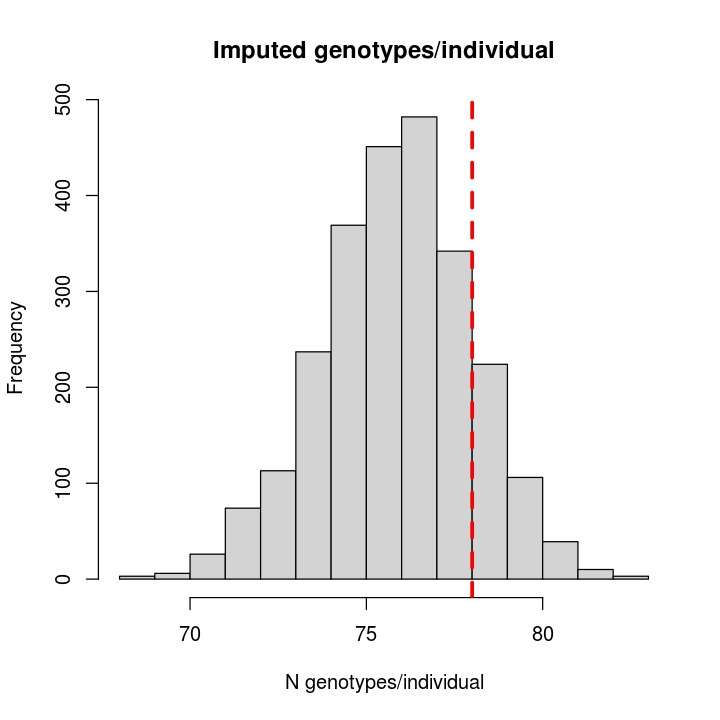

In [301]:
psize(6,6)
hist(colSums(hla_imputed[, !colnames(hla_imputed) %in% c("hla_type", "af")]), main = "Imputed genotypes/individual", xlab = "N genotypes/individual", ylab = "Frequency")
abline(v = 78, lty = "dashed", col = "#ff0000", lwd = 3)

In [266]:
gene2hla           = data.frame(hla_type = hla_imputed$hla_type, gene = unlist(lapply(hla_imputed$hla_type, function(x){unlist(strsplit(x, "\\."))[[1]]})))
rownames(gene2hla) = gene2hla$hla_type
gene2hla           = cbind(gene2hla, as.data.frame(rbindlist(lapply(gene2hla$hla_type, function(x)
{
    digits = unlist(strsplit(unlist(strsplit(x, "\\."))[[2]], ":"))
    x      = matrix("", nrow = 1, ncol = 4, dimnames = list(c(""), paste0("digit", (1:4) * 2)))
    
    for(ii in 1:length(digits))    
    {
        x[1, ii] = paste(digits[1:ii], collapse = ":")
    }
    
    if(length(digits) < 4)
    {
        for(ii in (length(digits) + 1):4)
        {
            x[1, ii] = paste(digits, collapse = ":")
        }
        
    }
    
    return(as.data.frame(x))
})), stringsAsFactors = FALSE))


In [226]:
gene2gt = as.data.frame(rbindlist(lapply(geneinfo$gene, function(gene)
{
    indata = colSums(hla_imputed[ hla_imputed$hla_type %in% gene2hla[ gene2hla$gene == gene, "hla_type"], ids])
    out    = data.frame(gene = gene, 
                        gt0  = length(indata[ indata == 0]) / length(ids),
                        gt1  = length(indata[ indata == 1]) / length(ids),
                        gt2  = length(indata[ indata == 2]) / length(ids),
                        gt3  = length(indata[ indata >= 3]) / length(ids)
                       )
    
    return(out)
})), stringsAsFactors = FALSE)


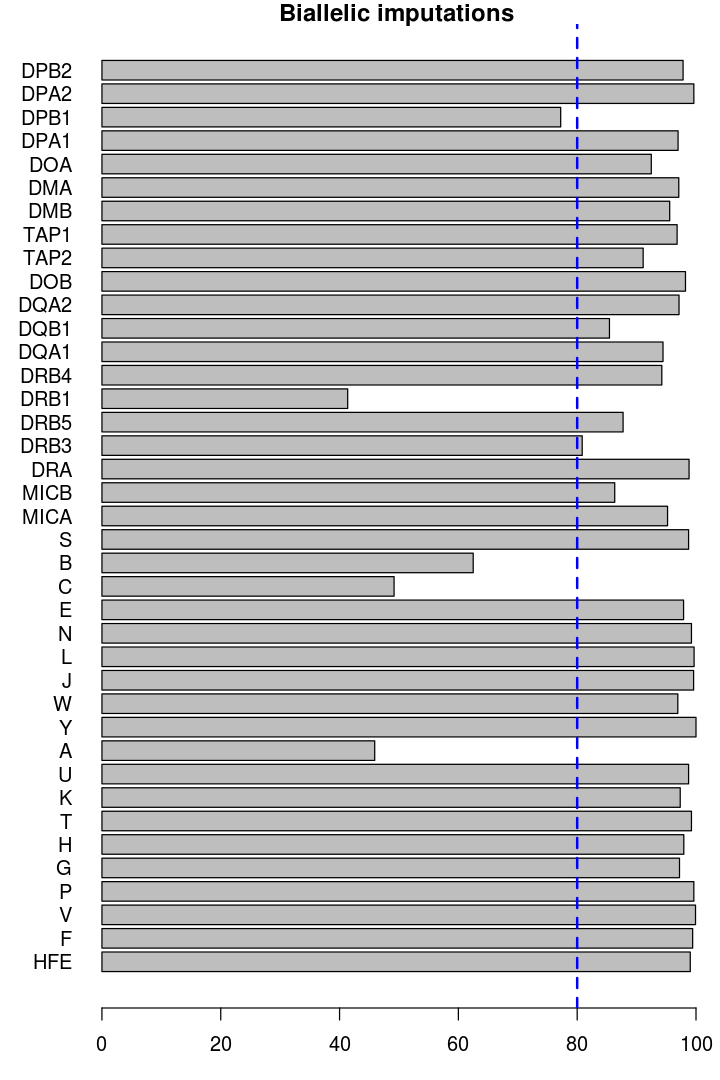

In [303]:
psize(6, 9)
par(mar = c(3,4,1,1))
barplot(gene2gt$gt2 * 100, names.arg = gene2gt$gene, horiz = TRUE, las = 1, main = "Biallelic imputations")
abline(v = 80, lty = "dashed", col = "#0000ff", lwd = 2)

In [235]:
gene2gt[ gene2gt$gt2 < 0.8, "gene"]
gene2gt[ gene2gt$gt2 < 0.9 & gene2gt$gt2 > 0.8, "gene"]


[1] "A"    "C"    "B"    "DRB1" "DPB1"

[1] "MICB" "DRB3" "DRB5" "DQB1"

In [250]:
check_concordance_by_gene = function(gene, x)
{
    x    = x[ x$gene == gene,]
    test = sum(abs(x$real - x$imputed))
    
    return(test)
}

test_concordance = function(id, hla_real, hla_imputed, gene2hla)
{
    indata         = gene2hla
    indata$real    = hla_real   [ indata$hla_type, id]
    indata$imputed = hla_imputed[ indata$hla_type, id]
    out            = data.frame(gene = sort(unique(indata$gene)), 
                                test = unlist(lapply(sort(unique(indata$gene)), function(gene){check_concordance_by_gene(gene, indata)})))
    out$concordant = ifelse(out$test == 0, yes = TRUE, no = FALSE)
    
    return(out)
}

id = "NA12718"
concordance = as.data.frame(rbindlist(lapply(ids, function(id){test_concordance(id, hla_real, hla_imputed, gene2hla)})))

fwrite(concordance, "pipeline/beagle/1kgp_validation/concordance.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [253]:
concordance_by_gene = concordance %>% group_by(gene) %>% summarize(concordance = mean(concordant))

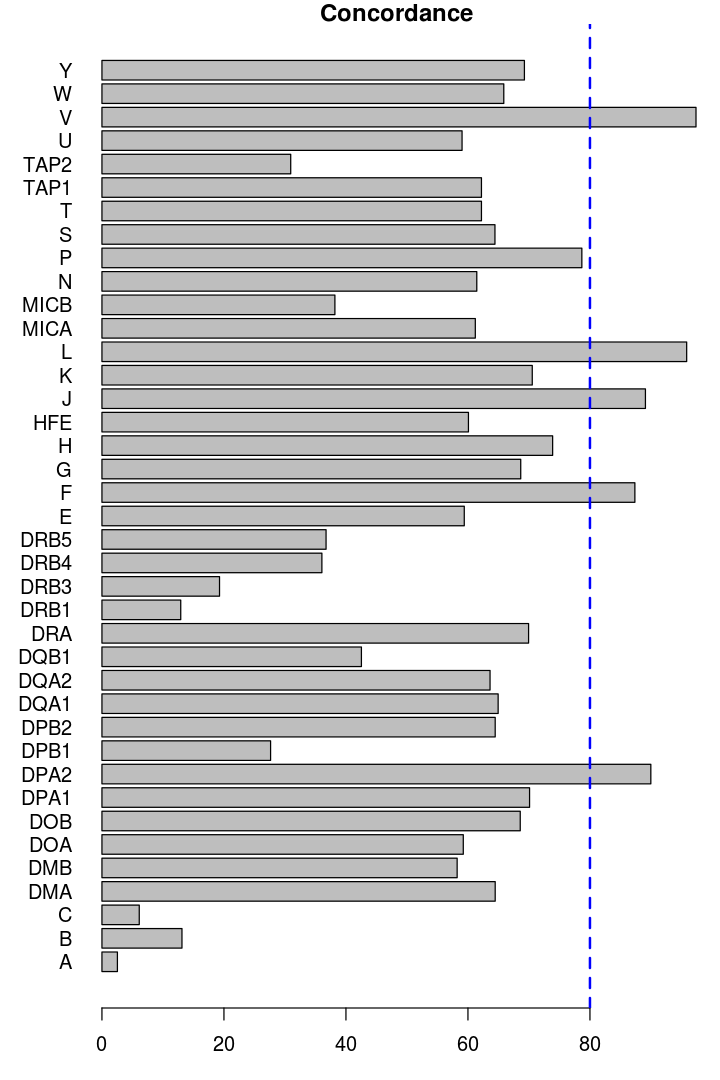

In [304]:
par(mar = c(3,4,1,1))
barplot(concordance_by_gene$concordance * 100, names.arg = concordance_by_gene$gene, horiz = TRUE, las = 1, main = "Concordance")
abline(v = 80, lty = "dashed", col = "#0000ff", lwd = 2)

In [267]:
str(gene2hla)

'data.frame':	2650 obs. of  6 variables:
 $ hla_type: chr  "HFE.001:01:02" "HFE.001:01:01" "HFE.001:01:03" "F.01:01:01:09" ...
 $ gene    : chr  "HFE" "HFE" "HFE" "F" ...
 $ digit2  : chr  "001" "001" "001" "01" ...
 $ digit4  : chr  "001:01" "001:01" "001:01" "01:01" ...
 $ digit6  : chr  "001:01:02" "001:01:01" "001:01:03" "01:01:01" ...
 $ digit8  : chr  "001:01:02" "001:01:01" "001:01:03" "01:01:01:09" ...


In [ ]:
check_concordance_by_digit = function(gene, x)
{
    x    = x[ x$gene == gene,]
    test = sum(abs(x$real - x$imputed))
    b
    return(test)
}

test_concordance_digit = function(id, digit, hla_real, hla_imputed, gene2hla)
{
    indata          = gene2hla
    indata$real     = hla_real   [ indata$hla_type, id]
    indata$imputed  = hla_imputed[ indata$hla_type, id]
    indata$hla_type = indata[, digit]
    indata          = suppressMessages(indata %>% group_by(gene, hla_type) %>% summarize(real = sum(real), imputed = sum(imputed)))
    out             = data.frame(gene  = sort(unique(indata$gene)), 
                                 digit = digit,
                                 test  = unlist(lapply(sort(unique(indata$gene)), function(gene){check_concordance_by_gene(gene, indata)})))
    out$concordant  = ifelse(out$test == 0, yes = TRUE, no = FALSE)
    
    return(out)
}

id    = "NA12718"
digit = 2
#test_concordance_digit(id, digit, hla_real, hla_imputed, gene2hla)

psize(15,7)
layout(rbind(1:4))

digits            = paste0("digit", (1:4)*2)
concordance_digit = lapply(rev(digits), function(digit)
{
    message(digit, appendLF = FALSE)
    out                 = as.data.frame(rbindlist(lapply(ids, function(id){test_concordance_digit(id, digit, hla_real, hla_imputed, gene2hla)})), stringsAsFactors = FALSE)
    concordance_by_gene = out %>% group_by(gene) %>% summarize(concordance = mean(concordant))
    
    barplot(concordance_by_gene$concordance * 100, names.arg = concordance_by_gene$gene, horiz = TRUE, las = 1, main = digit)
    abline(v = 80, lty = "dashed", col = "#0000ff", lwd = 2)
    
    return(out)
})

names(concordance_digit) = rev(digits)

#
#fwrite(concordance, "pipeline/beagle/1kgp_validation/concordance.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

digit8
digit6
digit4
digit2


In [293]:
a = lapply(digits, function(digit)
{
    message(digit, appendLF = FALSE)
    
    x                   = concordance_digit[[digit]]
    concordance_by_gene = x %>% group_by(gene) %>% summarize(concordance = mean(concordant))
    concordance_by_gene = concordance_by_gene[ concordance_by_gene$concordance >= 0.8, "gene"]
    
    message(paste(nrow(concordance_by_gene), paste(concordance_by_gene, collapse = "; "), sep = ": "))
    
    return(concordance_by_gene)
})

digit2
24: c("DMA", "DMB", "DOA", "DOB", "DPA1", "DPA2", "DPB2", "DQA1", "DQA2", "DRA", "E", "F", "G", "H", "HFE", "J", "K", "L", "N", "P", "S", "TAP1", "U", "V")

digit4
17: c("DMA", "DOA", "DOB", "DPA1", "DPA2", "DPB2", "DRA", "F", "G", "H", "HFE", "J", "L", "N", "P", "TAP1", "V")

digit6
14: c("DMA", "DPA1", "DPA2", "DPB2", "DRA", "F", "G", "H", "J", "L", "N", "P", "TAP1", "V")

digit8
5: c("DPA2", "F", "J", "L", "V")



In [297]:
gene2hla[ gene2hla$gene == "F",]

,hla_type,gene,digit2,digit4,digit6,digit8
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F.01:01:01:09,F.01:01:01:09,F,01,01:01,01:01:01,01:01:01:09
F.01:01:01:01,F.01:01:01:01,F,01,01:01,01:01:01,01:01:01:01
F.01:01:01:08,F.01:01:01:08,F,01,01:01,01:01:01,01:01:01:08
F.01:01:02:09,F.01:01:02:09,F,01,01:01,01:01:02,01:01:02:09
F.01:03:01:01,F.01:03:01:01,F,01,01:03,01:03:01,01:03:01:01
F.01:01:02:10,F.01:01:02:10,F,01,01:01,01:01:02,01:01:02:10
F.01:01:01:17,F.01:01:01:17,F,01,01:01,01:01:01,01:01:01:17
F.01:01:02:08,F.01:01:02:08,F,01,01:01,01:01:02,01:01:02:08
F.01:01:01:18,F.01:01:01:18,F,01,01:01,01:01:01,01:01:01:18


In [295]:
gene2hla %>% group_by(gene) %>% summarize(types = length(hla_type))

gene,types
<chr>,<int>
A,677
B,444
C,439
DMA,5
DMB,8
DOA,5
DOB,5
DPA1,48
DPA2,5


# Compare with imputation using only UKBB variants (10-step cross-validation removing some random variants)

In [192]:
id2cv_random = fread("pipeline/beagle/1kgp_validation/random/id2cv.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [193]:
cv2perm = fread("pipeline/beagle/1kgp_validation/random/cv2perm.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [194]:
cv2perm$name = paste(paste0("bin", cv2perm$bin), cv2perm$random, cv2perm$perm, sep = ".")

In [ ]:
read_imputed_hla_random = function(ii, cv2perm, id2cv)
{
    bin             = cv2perm[ii, "bin"   ]
    random          = cv2perm[ii, "random"]
    perm            = cv2perm[ii, "perm"  ]
    ids             = id2cv[ id2cv$bin == bin, "id"]
    vcf_imputed_hla = paste(getwd(), "pipeline/beagle/1kgp_validation/random/processing", paste(paste0("bin", bin), random, perm, sep = "."), "imputed_hla.vcf.gz", sep = "/")
    command = paste("bcftools", "query",
                    "-s", paste(ids, collapse = ","),
                    "-f", "'%ID\\t%AF[\\t%DS]\\n'",
                    vcf_imputed_hla
                   )

    hla_imputed           = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    #colnames(hla_imputed) = unlist(lapply(colnames(hla_imputed), function(x){unlist(strsplit(x, ""))}))
    colnames(hla_imputed) = c("hla_type", "af", ids)
    rownames(hla_imputed) = hla_imputed$hla_type
    
    return(hla_imputed)
}

cv2perm_read                   = cv2perm[ cv2perm$random != 100, ]
hla_imputed_random_list        = lapply(1:nrow(cv2perm_read), function(ii){read_imputed_hla_random(ii, cv2perm_read, id2cv_random)})
names(hla_imputed_random_list) = cv2perm_read$name



In [196]:
cv2perm_all                 = cv2perm[ 9991:10000, ]
hla_imputed_all_list        = lapply(1:nrow(cv2perm_all), function(ii){read_imputed_hla_random(ii, cv2perm_all, id2cv_random)})
names(hla_imputed_all_list) = cv2perm_all$name


In [201]:
hla_imputed_all_random_list = c(hla_imputed_random_list, hla_imputed_all_list)
cv2perm_all                 = cv2perm[ cv2perm$name %in% names(hla_imputed_all_random_list),]

saveRDS(hla_imputed_all_random_list, "pipeline/beagle/1kgp_validation/random/hla_imputed.rds")



In [202]:
randoms = sort(unique(cv2perm_all$random))
#perms   = sort(unique(cv2perm_all$perm  ))

hla_imputed_random = lapply(randoms, function(random)
{
    perms = sort(unique(cv2perm_all[ cv2perm_all$random == random, "perm"]))
    out   = lapply(perms, function(perm)
    {
        to_cbind = paste(paste0("bin", bins), random, perm, sep = ".")
        out_bins = cbind(hla_imputed_all_random_list[[1]][,c("hla_type", "af")], 
                         as.data.frame(do.call(cbind, lapply(hla_imputed_all_random_list[to_cbind], function(x)
                         {
                             x[, !colnames(x) %in% c("hla_type", "af")]
                         })), stringsAsFactors = FALSE))
        
        for(x in to_cbind)
        {
            colnames(out_bins) = sub(paste0(x, "."), "", colnames(out_bins))
        }
        
        out_bins           = out_bins[,c("hla_type", "af", ids)]
        rownames(out_bins) = out_bins$hla_type
        
        return(out_bins)
    })
    
    names(out) = paste0("perm", perms)
    
    return(out)
})

names(hla_imputed_random) = paste0("random", randoms)

saveRDS(hla_imputed_random, "pipeline/beagle/1kgp_validation/random/hla_imputed_gts.rds")

In [203]:
diff_random = as.data.frame(rbindlist(lapply(randoms, function(random)
{
    perms = sort(unique(cv2perm_all[ cv2perm_all$random == random, "perm"]))
    as.data.frame(rbindlist(lapply(perms, function(perm)
    {
        mydiff           = as.matrix(hla_real[ rownames(hla_imputed), ids]) - as.matrix(hla_imputed_random[[paste0("random", random)]][[paste0("perm", perm)]][,ids])
        rownames(mydiff) = hla_imputed$hla_type
        out_bins         = data.frame(random = random, perm = perm, diff = sum(abs(mydiff))/length(mydiff))
        
        return(out_bins)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

#diff_random = rbind(diff_random, data.frame(random = 100, perm = 0, diff = diff_ukbb_all))

In [204]:
fwrite(diff_random, "pipeline/beagle/1kgp_validation/random/imputation_accuracy.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

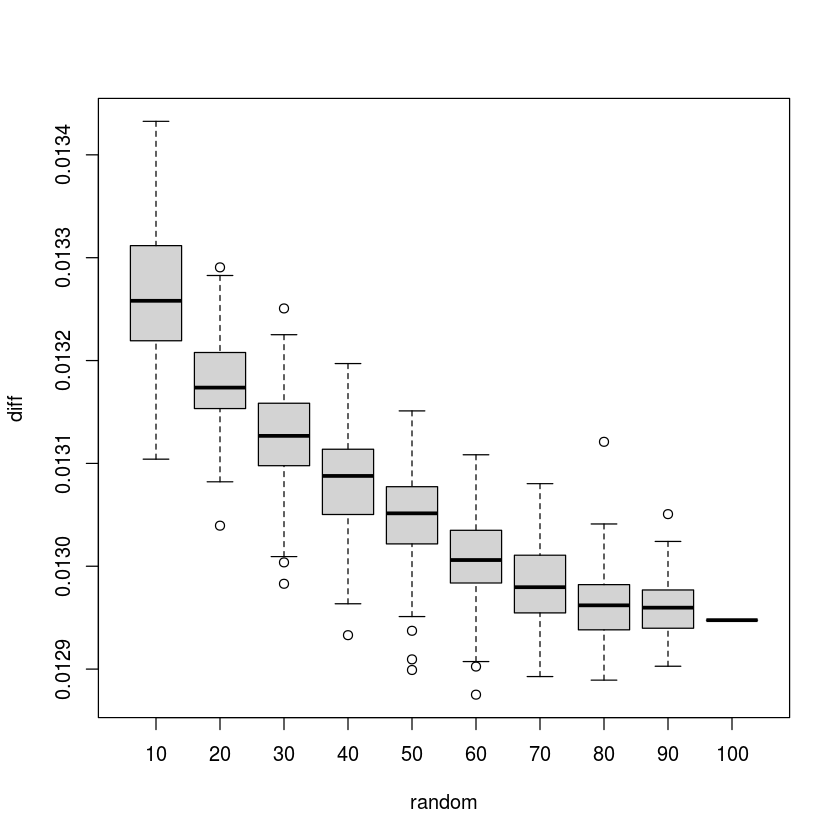

In [205]:
boxplot(diff ~ random, data = diff_random)

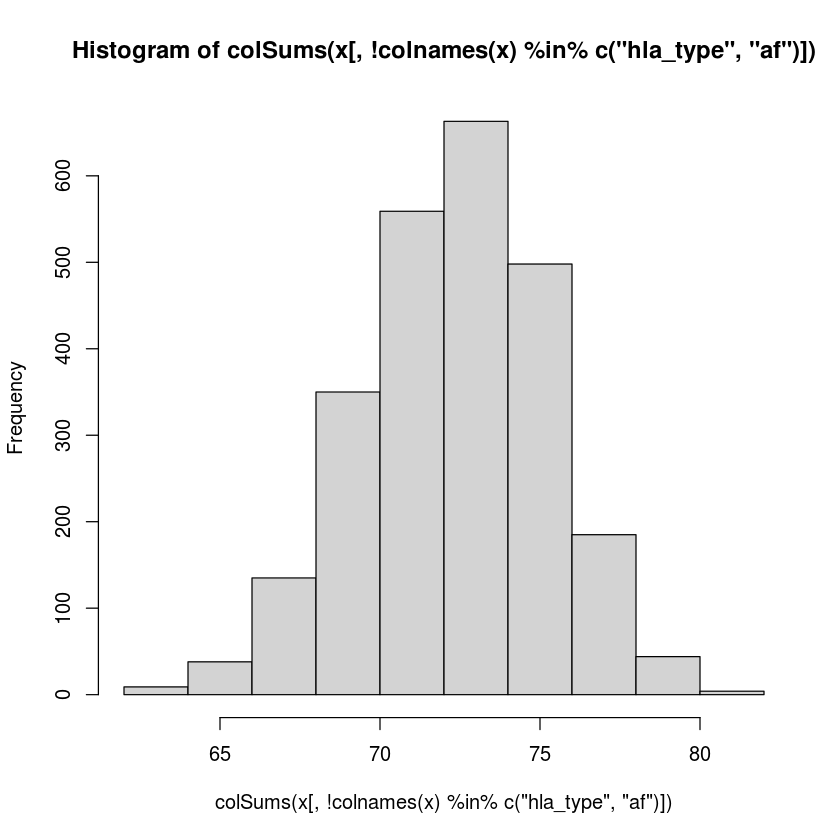

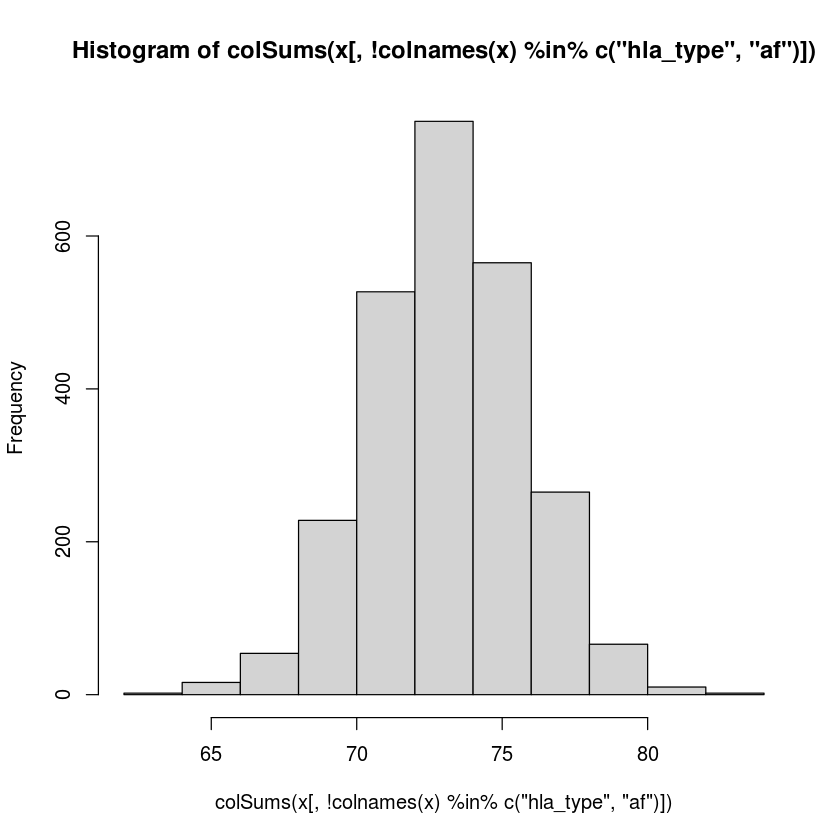

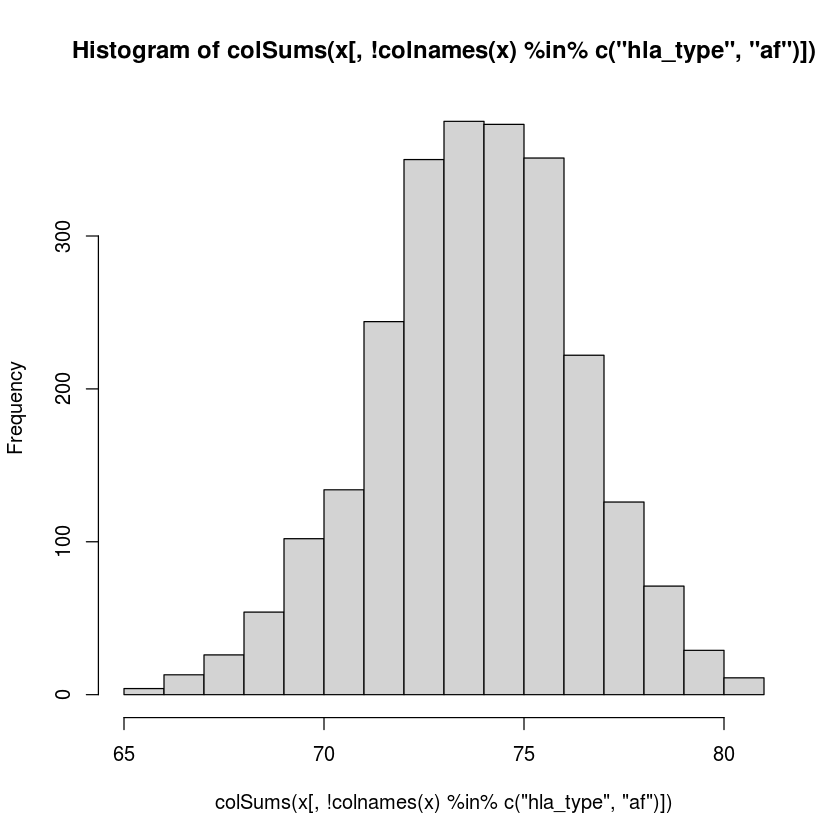

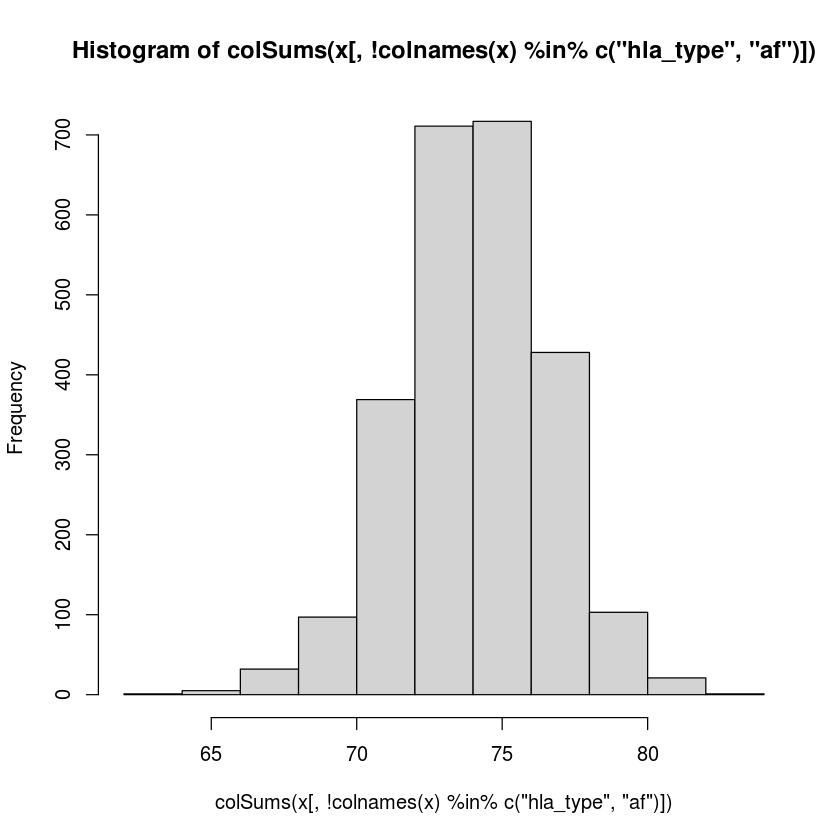

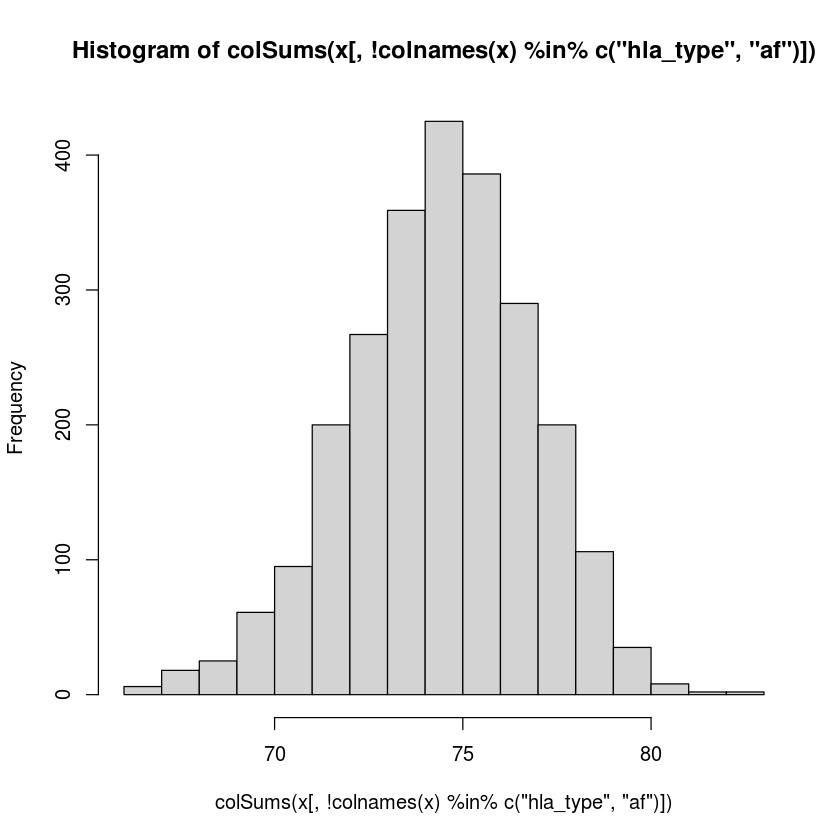

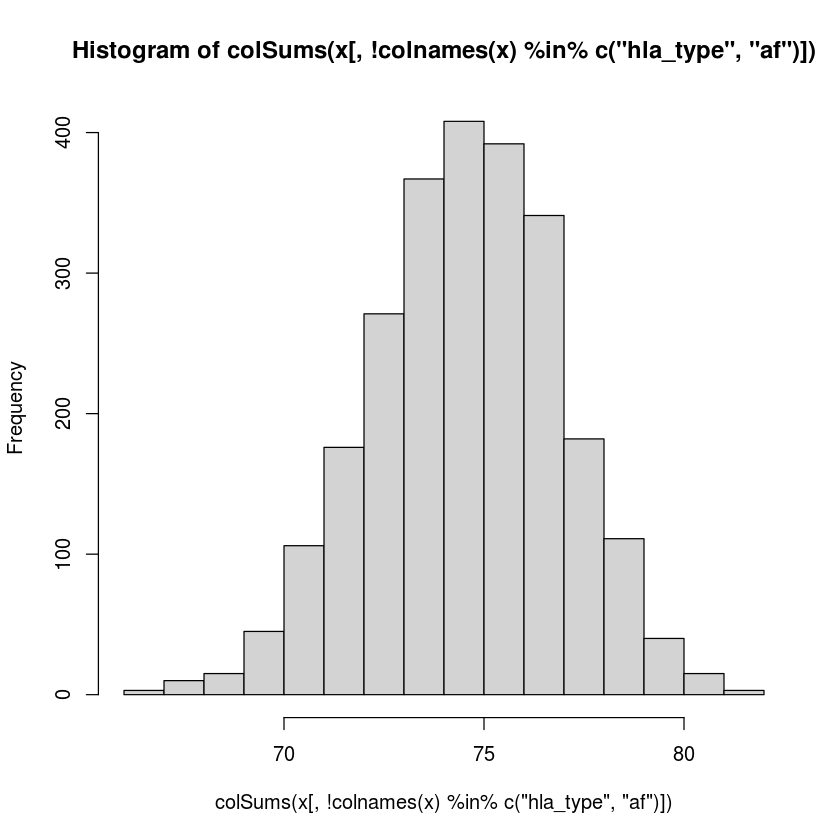

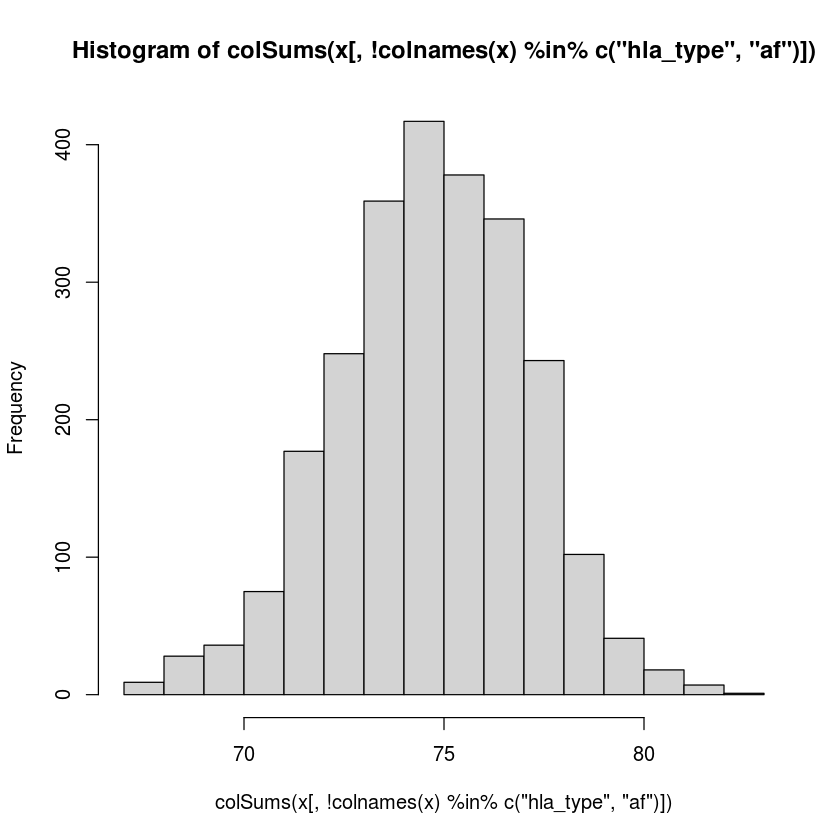

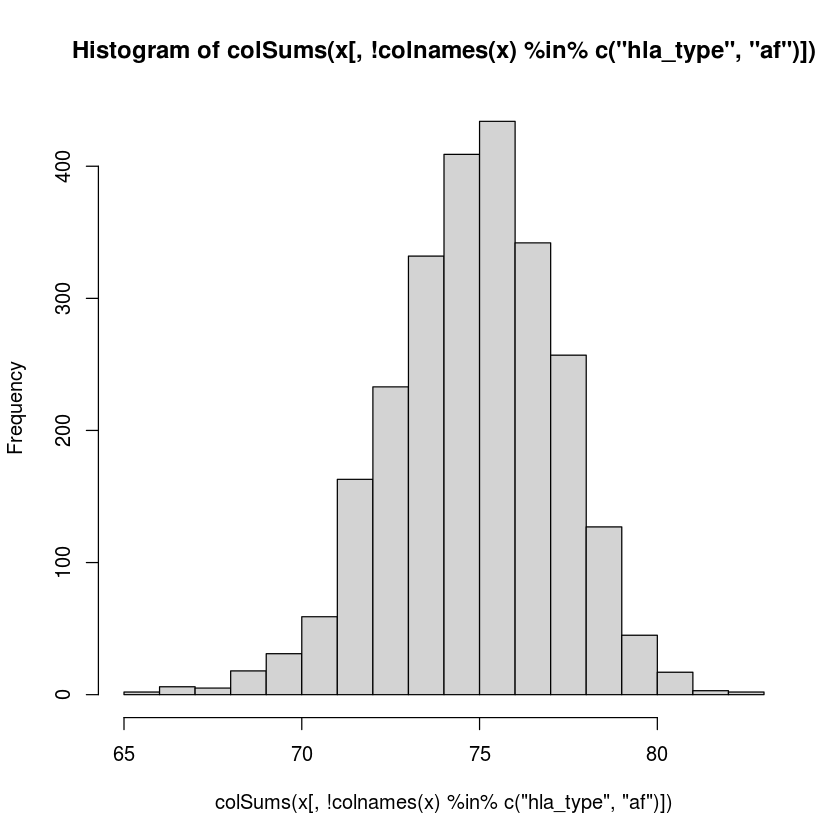

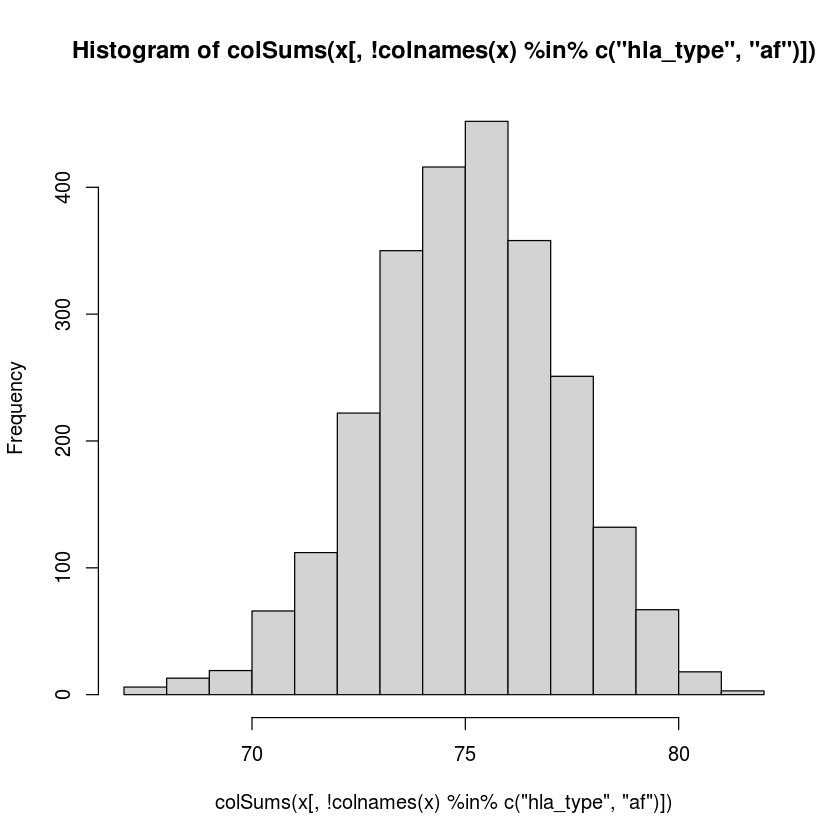

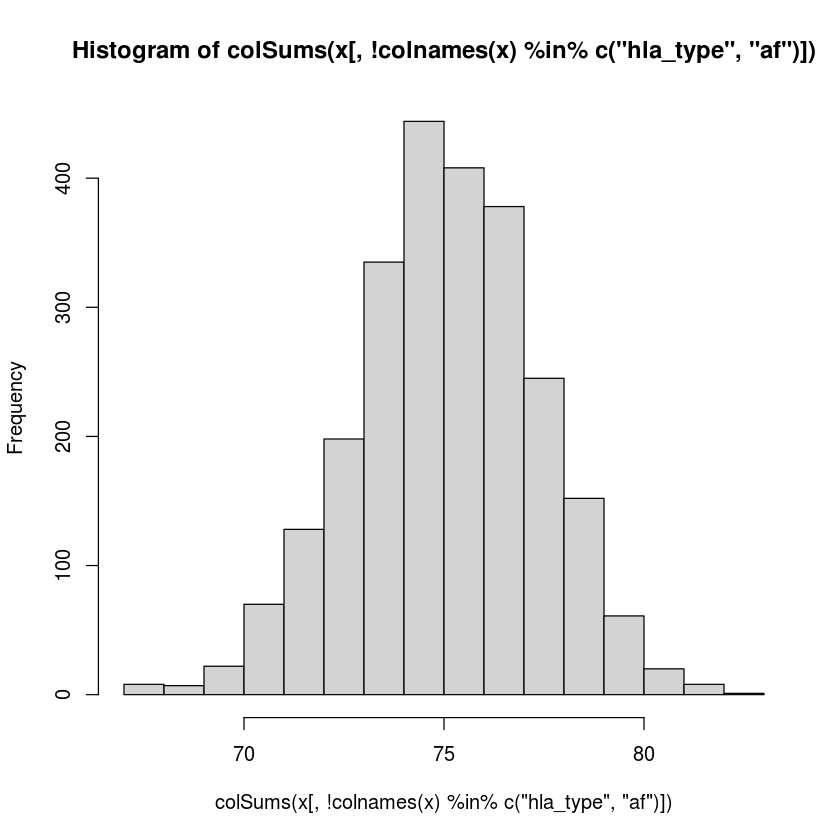

In [228]:
invisible(lapply(hla_imputed_random, function(x)
{
    x = x[[1]]
    hist(colSums(x[, !colnames(x) %in% c("hla_type", "af")]))
}))


In [214]:
str(hla_imputed_random[[1]])

# Do some tests on HLA typing

In [208]:
str(hla_imputed)

'data.frame':	2650 obs. of  2487 variables:
 $ hla_type: chr  "HFE.001:01:02" "HFE.001:01:01" "HFE.001:01:03" "F.01:01:01:09" ...
 $ af      : num  0.495 0.34 0.165 0.21 0.136 ...
 $ NA12718 : int  1 0 1 0 0 0 1 1 0 0 ...
 $ NA12748 : int  1 0 1 0 2 0 0 0 0 0 ...
 $ NA12775 : int  2 0 0 0 1 1 0 0 0 0 ...
 $ NA12777 : int  1 0 1 0 0 0 0 1 0 0 ...
 $ NA12778 : int  0 1 1 0 2 0 0 0 0 0 ...
 $ NA12827 : int  1 0 1 1 1 0 0 0 0 0 ...
 $ NA12829 : int  0 1 1 0 2 0 0 0 0 0 ...
 $ NA12842 : int  0 0 2 1 0 0 1 0 0 0 ...
 $ NA12843 : int  1 0 1 0 0 0 0 2 0 0 ...
 $ NA12889 : int  1 0 1 0 0 0 0 2 0 0 ...
 $ NA12890 : int  0 1 1 0 1 0 0 1 0 0 ...
 $ NA18488 : int  2 0 0 1 0 0 0 0 0 1 ...
 $ NA18530 : int  2 0 0 1 1 0 0 0 0 0 ...
 $ NA18534 : int  2 0 0 0 0 0 1 0 1 0 ...
 $ NA18536 : int  0 0 2 1 1 0 0 0 0 0 ...
 $ NA18543 : int  0 0 2 1 0 0 1 0 0 0 ...
 $ NA18544 : int  1 1 0 1 0 0 1 0 0 0 ...
 $ NA18546 : int  1 1 0 0 1 0 1 0 0 0 ...
 $ NA18548 : int  2 0 0 1 0 0 0 0 0 0 ...
 $ NA18549 : int  2 0 

In [209]:
str(hla_real)

'data.frame':	2650 obs. of  2487 variables:
 $ hla_type: chr  "HFE.001:01:02" "HFE.001:01:01" "HFE.001:01:03" "F.01:01:01:09" ...
 $ af      : num  0.505 0.337 0.158 0.214 0.141 ...
 $ NA12718 : int  1 0 1 0 0 0 1 1 0 0 ...
 $ NA12748 : int  1 0 1 0 2 0 0 0 0 0 ...
 $ NA12775 : int  2 0 0 0 1 1 0 0 0 0 ...
 $ NA12777 : int  1 0 1 0 0 0 0 1 0 0 ...
 $ NA12778 : int  0 1 1 0 2 0 0 0 0 0 ...
 $ NA12827 : int  1 0 1 1 1 0 0 0 0 0 ...
 $ NA12829 : int  0 1 1 0 2 0 0 0 0 0 ...
 $ NA12842 : int  0 1 1 1 0 0 1 0 0 0 ...
 $ NA12843 : int  1 0 1 0 0 0 0 2 0 0 ...
 $ NA12889 : int  1 0 1 0 0 0 0 2 0 0 ...
 $ NA12890 : int  0 2 0 0 1 0 0 1 0 0 ...
 $ NA18488 : int  2 0 0 1 0 0 0 0 0 1 ...
 $ NA18530 : int  1 0 1 1 1 0 0 0 0 0 ...
 $ NA18534 : int  1 1 0 0 0 0 1 0 1 0 ...
 $ NA18536 : int  1 0 1 1 1 0 0 0 0 0 ...
 $ NA18543 : int  1 0 1 1 0 0 1 0 0 0 ...
 $ NA18544 : int  2 0 0 1 0 0 1 0 0 0 ...
 $ NA18546 : int  1 0 1 0 1 0 1 0 0 0 ...
 $ NA18548 : int  2 0 0 1 0 0 0 0 0 0 ...
 $ NA18549 : int  2 